<a href="https://colab.research.google.com/github/jaimemv/twitter_covide_fake_news_dectector_covid19/blob/main/Zenodo_Covid_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

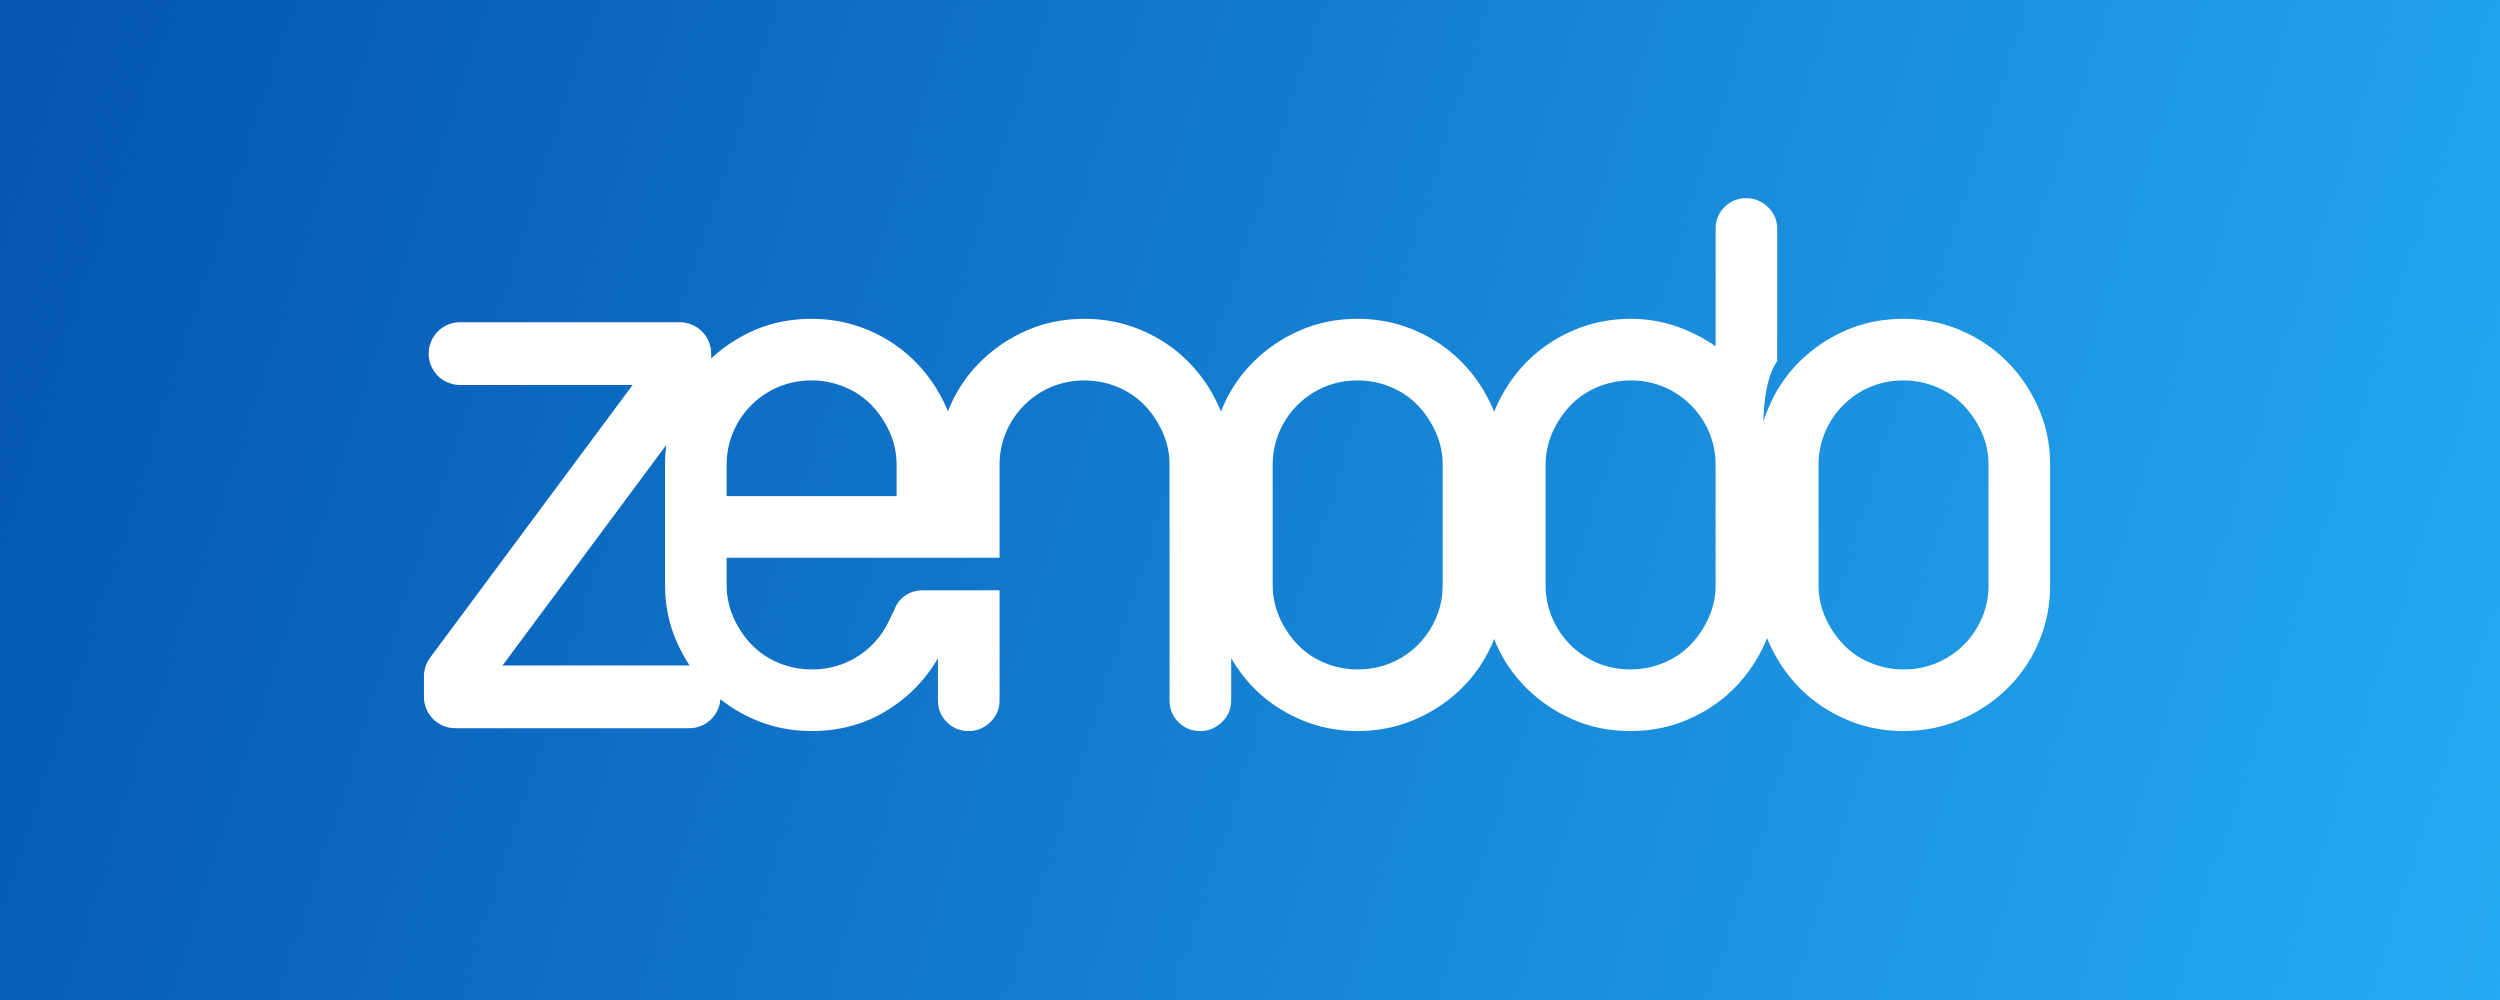

# Brief Introduction
This Colab Notebook is the main script of my Data Science project for the team of Zenodo. The aim is **generating extra value from an open resource of Zenodo**. In addition to open manually annotated datasets from institutions like The Pennsylvania State University(2), this open science resources make possible the progress toward the global health. 

# Background
**Fake News have become a major concern** during the last years. Thanks to the advances in technology and its accessibility, anyone can post/upload any Fake News and widely spread them through the network.

This becomes a **risky issue when it comes to COVID-19** pandemic topic. In this matter it hurts not only the reached person who believes them but also to the common health, as everybody can be a focus of spread of the virus.

This notebooks intends to support the management of content on the Social Networks during the COVID-19 pandemic. 
For that, it's been built a Deep Learning classifier using `BERT` model and two of its variants: `Albert` and `Roberta`.
The purpose of this classifier is to detect whether a tweet is *fake news* and might: 
1. Under-rank them in the feeds 
2. Ban the content
3. Raise a disclaimer announcing that the content might be fake-news.

The steps followed have been:
1. Research for a labelled datasets.
2. Data mining on labelled datasets.
3. Build, train and evaluate several `BERT` models and choose the best one.
4. Retrieve dataset from Zenodo and hydrate tweets.
5. Run predictions over Zenodo dataset.

# Install and import needed dependencies

In order to keep this notebook clean, the datasets were previously fetched, minned and hosted in my personal drive. If needed please ask me for access.

In [ ]:
from IPython.display import clear_output
!pip install wget
!pip install simpletransformers
!pip install emoji
!pip install bert-for-tf2
!pip install tweet-preprocessor
!pip install itertools
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

!unzip uncased_L-12_H-768_A-12.zip
# Fetch covid dataset from Zenodo
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1-0a2NycPehbHRlp2jXm357XBkzcPdgtk' -O zenodo_covid_dataset.csv
# Fetch merged labelled datasets
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1lmlWFKTbHo7lhG8YNqPB21BTlaeif7Xu' -O covid_clean_dataset_09_02_21.csv

clear_output()

In [ ]:
import pandas as pd
import numpy as np
import wget
from sklearn.model_selection import train_test_split
import re
import sklearn
import itertools
import emoji
import os

try:
  from simpletransformers.classification import ClassificationModel
  clear_output()
except:
  clear_output()

May need to restart runtime to properly import `simpletransformers.classification.ClassificationModel`.


In [ ]:
from simpletransformers.classification import ClassificationModel

Finally import hte labelled dataset in order to train the model:

In [ ]:
df = pd.read_csv("/content/covid_clean_dataset_09_02_21.csv",
                 usecols=["text", "target"])#.dropna()

## Text mining

In [ ]:
def load_dict_contractions(): 
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks"
        }


In [ ]:
def remove_contractions(tweet):
  contractions = load_dict_contractions()
  return contractions[tweet.lower()] if tweet.lower() in contractions.keys() else tweet

def clean_text(tweet):
    # Remove hashtags (keeping hashtag text)
    tweet = re.sub(r'#','', tweet)
    # HTML 
    tweet = re.sub(r'\&\w*;', '', tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove whitespaces
    tweet = re.sub(r'\s\s+','', tweet)
    tweet = re.sub(r'[ ]{2, }',' ',tweet)
    # Remove URLs, RTs and mentions(@)
    tweet=  re.sub(r'http(\S)+', '',tweet)
    tweet=  re.sub(r'http ...', '',tweet)
    tweet=  re.sub(r'(RT|rt)[ ]*@[ ]*[\S]+','',tweet)
    tweet=  re.sub(r'RT[ ]?@','',tweet)
    tweet = re.sub(r'@[\S]+','',tweet)
    # Remove words with 4 or fewer characters
    tweet = re.sub(r'\b\w{1,4}\b', '', tweet)
    # Special characteres: &, <, >
    tweet = re.sub(r'&amp;?', 'and',tweet)
    tweet = re.sub(r'&lt;','<',tweet)
    tweet = re.sub(r'&gt;','>',tweet)
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet= ''.join(c for c in tweet if c <= '\uFFFF') 
    tweet = tweet.strip()
    # Remove misspelling words
    tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))
    # Remove emoji
    tweet = emoji.demojize(tweet)
    tweet = tweet.replace(":"," ")
    tweet = ' '.join(tweet.split()) 
    tweet = re.sub("([^\x00-\x7F])+"," ",tweet)
    # Remove mojibake (also extra spaces)
    tweet = ' '.join(re.sub("[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", tweet).split())
    return tweet

In [ ]:
df["text"] = df["text"].apply(remove_contractions)
df["text"] = df["text"].apply(clean_text)

In [ ]:
df.drop_duplicates(subset=["text"], inplace=True)
df.dropna(inplace=True)

# TRAIN AND EVALUATE THE MODELS:
(1)`BERT`, (2)`Roberta` and (3)`Albert`
Check which one performs better and make the predictions on Zenodo hydrated tweets.



We'll be using BERT for TensorFlow2:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [ ]:
train_args = {
    'evaluate_during_training': True,
    'logging_steps': 100,
    'num_train_epochs': 5,
    'evaluate_during_training_steps': 100,
    'save_eval_checkpoints': False,
    'train_batch_size': 32,
    'eval_batch_size': 64,
    'overwrite_output_dir': True,
    'fp16': False,
    'wandb_project': "covid"
}

`wandb` API key:

1368ef9ecb109eea86444b12d3a6465b8f46dd9b

### BERT

In [ ]:
model_BERT = ClassificationModel('bert', 'bert-base-cased', num_labels=2, use_cuda=True, cuda_device=0, args=train_args)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [ ]:
model_BERT.train_model(train_df, eval_df=val_df)

In [ ]:
result, model_outputs, wrong_predictions = model_BERT.eval_model(val_df, acc=sklearn.metrics.accuracy_score)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/77 [00:00<?, ?it/s]

Training loss,9e-05
lr,0.0
global_step,2295
_runtime,1540
_timestamp,1613139508
_step,48
tp,2144
tn,2621
fp,57
fn,65
mcc,0.9496


Training loss,▆█▅▄▁▂▁▃▁▂▅▁▁▄▁▃▁▁▄▁▁▁
lr,▆██▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
tp,▁▇▆▇▇█▄▇▆▇▄██▇▇██▇▅▆▇▇▆▇▇▇▇
tn,▁▁▅▆▅▄█▆▆▆█▅▆▆▇▆▆▇█▇▇▆▇▇▇▆▇
fp,██▄▃▄▅▁▃▃▃▁▄▃▃▂▃▃▂▁▂▂▃▂▂▂▃▂
fn,█▂▃▂▂▁▅▂▃▂▅▁▁▂▂▁▁▂▄▃▂▂▃▂▂▂▂
mcc,▁▄▆▇▇▇▆█▇█▇████████████████


## Roberta

In [ ]:
model_Roberta = ClassificationModel('roberta', 'roberta-base', num_labels=2, use_cuda=True, cuda_device=0, args=train_args)

In [ ]:
model_Roberta.train_model(train_df, eval_df=val_df)

In [ ]:
result, model_outputs, wrong_predictions = model_Roberta.eval_model(val_df, acc=sklearn.metrics.accuracy_score)

## Albert

In [ ]:
model_albert = ClassificationModel('albert', 'albert-base-v2', num_labels=2, use_cuda=True, cuda_device=0, args=train_args)

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

In [ ]:
model_albert.train_model(train_df, eval_df=val_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:446: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

_runtime,6
_timestamp,1613141111
_step,2


_runtime,▁▁█
_timestamp,▁▁█
_step,▁▅█


Running Epoch 0 of 5:   0%|          | 0/459 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running Epoch 1 of 5:   0%|          | 0/459 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/459 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/459 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/459 [00:00<?, ?it/s]

(2295,
 {'auprc': [0.9507103812018843,
   0.9646388040463377,
   0.9642957118890779,
   0.9859570828744698,
   0.9857248051176191,
   0.9832521693056363,
   0.9826746530863457,
   0.9892990649417378,
   0.9852842632960364,
   0.9674200035574424,
   0.9905503611207389,
   0.9882008337930899,
   0.9927762660711983,
   0.9942801786490906,
   0.9899340662500475,
   0.9932443455096277,
   0.9932836313747634,
   0.9936181942248463,
   0.9925125400474992,
   0.9949596861155657,
   0.9939779784686732,
   0.9943074172878551,
   0.9942648810818724,
   0.9943232018595046,
   0.9932540528201969,
   0.9940843885389721,
   0.9942067376055617],
  'auroc': [0.954937216242468,
   0.9657278206373479,
   0.9744963488695002,
   0.9872552741838585,
   0.9873220456338064,
   0.9831627759478081,
   0.9855296970672289,
   0.9902833171785866,
   0.9884083072473901,
   0.978255835064038,
   0.9913415178790277,
   0.9908222219442426,
   0.9934695831534449,
   0.9949091418059935,
   0.9886595031325107,
   0.99308

In [ ]:
result, model_outputs, wrong_predictions = model_albert.eval_model(val_df, acc=sklearn.metrics.accuracy_score)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/77 [00:00<?, ?it/s]

Training loss,0.03527
lr,0.0
global_step,2295
_runtime,1543
_timestamp,1613142667
_step,48
tp,2165
tn,2595
fp,83
fn,44
mcc,0.94775


Training loss,▇▇▄▁█▅▄▁▄▁▁▁▃▂▁▁▃▁▃▁▁▂
lr,▆██▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
tp,▂▂▇▇▇▁▅▆▆█▄▇▇█▅▇▇▇█▇██▇████
tn,▄▆▁▅▅█▇▆▇▁█▆▆▇█▇▇▇▆█▇▇▇▇▇▇▇
fp,▅▃█▄▄▁▂▃▂█▁▃▃▂▁▂▂▂▃▁▂▂▂▂▂▂▂
fn,▇▇▂▂▂█▄▃▃▁▅▂▂▁▄▂▂▂▁▂▁▁▂▁▁▁▁
mcc,▁▃▃▆▆▄▆▆▇▄▆▇▇█▆███▇████████


# Evaluate on the test Set

The main goal is a classifier that prioritises higher precision than recall so it doesn't let any positive (*Fake News*) tweet to be spread through the network.

Thus, although `Albert` provides higher accuracy results, I'll be using `Roberta` that classifies less *false negatives*

The following report has been created with `wandb` dashboard. In later updates It'll be embedded and interactive.

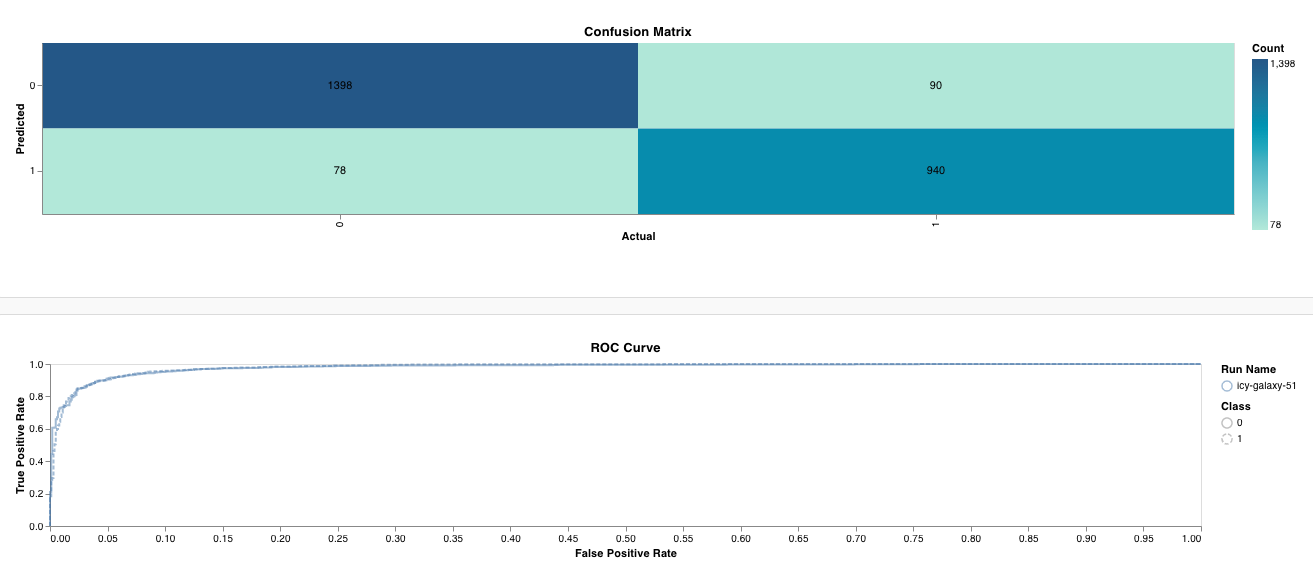

In [ ]:
test_df = pd.concat([X_test, y_test], axis=1)

In [ ]:
predictions, raw_outputs = model_albert.predict(list(X_test))

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
result, model_outputs, wrong_predictions = model_Roberta.eval_model(val_df, acc=sklearn.metrics.accuracy_score)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

_runtime,3
_timestamp,1613109216
_step,2


_runtime,▁▁▁
_timestamp,▁▁▁
_step,▁▅█


# Predict the stance on Zenodo dataset

In [ ]:
zenodo_tweets = pd.read_csv("/content/zenodo_covid_dataset.csv", usecols=["text"]).dropna()
#zenodo_tweets = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Zenodo_DS_Project/zenodo_covid_dataset_1.csv", usecols=["text"]).dropna()

## Dummy predictions

In [ ]:
def is_fake(tweet):
  print(f'Evaluating the following tweet:"{tweet}"')
  remove_contractions(tweet)
  clean_text(tweet)
  if model_albert.predict([tweet])[0] == [1]:
    print("The tweet is FAKE NEWS")
  else:
    print("The tweet is not FAKE NEWS")

In [ ]:
dummy_tweet_NO_FAKE = "Stay home in quarantine"
dummy_tweet_FAKE_NEWS = "COVID does not exist"

In [ ]:
is_fake(dummy_tweet_NO_FAKE)

Evaluating the following tweet:"Stay home in quarantine"


  0%|          | 0/1 [00:00<?, ?it/s]

The tweet is not FAKE NEWS


In [ ]:
is_fake(dummy_tweet_FAKE_NEWS)

Evaluating the following tweet:"COVID does not exist"


  0%|          | 0/1 [00:00<?, ?it/s]

The tweet is FAKE NEWS


In [ ]:
Text = 'COVID has been invented by Bill Gates' #@param {type:"string"}
is_fake(Text)

Evaluating the following tweet:"COVID has been invented by Bill Gates"


  0%|          | 0/1 [00:00<?, ?it/s]

The tweet is FAKE NEWS


In [ ]:
Text = 'Pay attention to experts to overcome covid pandemic' #@param {type:"string"}
is_fake(Text)

Evaluating the following tweet:"Pay attention to experts to overcome covid pandemic"


  0%|          | 0/1 [00:00<?, ?it/s]

The tweet is not FAKE NEWS


In [ ]:
Text = 'Please stay at home to avoid another COVID outbreak' #@param {type:"string"}
is_fake(Text)

Evaluating the following tweet:"Please stay at home to avoid another COVID outbreak"


  0%|          | 0/1 [00:00<?, ?it/s]

The tweet is not FAKE NEWS


In [ ]:
Text = 'Wear a mask to slow the spread of covid' #@param {type:"string"}
is_fake(Text)

Evaluating the following tweet:"Wear a mask to slow the spread of covid"


  0%|          | 0/1 [00:00<?, ?it/s]

The tweet is not FAKE NEWS


In [ ]:
Text = 'Bill Gates has created COVID' #@param {type:"string"}
is_fake(Text)

Evaluating the following tweet:"Bill Gates has created COVID"


  0%|          | 0/1 [00:00<?, ?it/s]

The tweet is FAKE NEWS


### Missclassified examples
The classifier is definitely not perfect, so I would also like to provide some examples where the classifier does not predict the expected outcome

In [ ]:
Text = 'Drink bleach to cure covid' #@param {type:"string"}
is_fake(Text)

## Actual predictions

In [ ]:
tweets_to_predict = list(zenodo_tweets.text.copy())

In [ ]:
predictions, raw_outputs = model_BERT.predict(tweets_to_predict)

  0%|          | 0/2352 [00:00<?, ?it/s]

In [ ]:
df_predictions = zenodo_tweets.copy()
df_predictions["predictions"] = pd.Series(predictions)

In [ ]:
df_predictions.predictions.value_counts()

1.0    78082
0.0    72427
Name: predictions, dtype: int64

# FAKE NEWS detector
Small application to input a text a predict whether it is FAKE NEWS or not.

In [ ]:
#@title Tweet Text
Text = 'Bill Gates has created COVID' #@param {type:"string"}
is_fake(Text)

Evaluating the following tweet:"Bill Gates has created COVID"


  0%|          | 0/1 [00:00<?, ?it/s]

The tweet is FAKE NEWS


In [ ]:
Text = 'Drink bleach to cure covid' #@param {type:"string"}
is_fake(Text)

Evaluating the following tweet:"Drink bleach to cure covid"


  0%|          | 0/1 [00:00<?, ?it/s]

The tweet is not FAKE NEWS


# Conclusions, opportunities and limitations
This project has been developed in very limited time. That's why I've opted to simplify the task choosing `simpletransformers` instead of building the entire `Transformer` model.

Nevertheless, it may be the benchmark to follow.

 If I were to continue with this project, I would make use of `covid-twitter-bert` model, which is pre-trained on a corpus of messages from Twitter about COVID-19. It would definitely yield state-of-the-art results. (See the link)
 https://tfhub.dev/digitalepidemiologylab/covid-twitter-bert/2
 
Furthermore I would allocate some funds to annotate more data, specially the latest in order to recognise recent FAKE NEWS patterns.



# References and datasets:
1. 
```
Banda, Juan M., Tekumalla, Ramya, Wang, Guanyu, Yu, Jingyuan, Liu, Tuo, Ding, Yuning, … Chowell, Gerardo.
(2021). 
A large-scale COVID-19 Twitter chatter dataset for open scientific research - an international collaboration.
(Version 47)
[Data set]. 
Zenodo. http://doi.org/10.5281/zenodo.4484079
```
2.
``` 
Limeng Cui, Dongwon Lee.
(2020).
CoAID: COVID-19 Healthcare Misinformation Dataset
[Data set]
arXiv:2006.00885
```
3. 
```
Firoj Alam, Shaden Shaar, Alex Nikolov, Hamdy Mubarak, Giovanni Da San Martino, Ahmed Abdelali, Fahim Dalvi, Nadir Durrani, Hassan Sajjad, Kareem Darwish, Preslav Nakov.
Fighting the COVID-19 Infodemic: Modeling the Perspective of Journalists, Fact-Checkers, Social Media Platforms, Policy Makers, and the Society"
arxiv, https://arxiv.org/abs/2005.00033.
```
4. 
```
@article{fameforsale2015,
 author = {Cresci, Stefano and {Di Pietro}, Roberto and Petrocchi, Marinella and Spognardi, Angelo and Tesconi, Maurizio},
 title = {Fame for sale: efficient detection of fake Twitter followers},
 journal = {Decision Support Systems},
 publisher = {Elsevier},
 volume = {80},
 month = {December},
 issn = {0167-9236},
 doi = {http://dx.doi.org/10.1016/j.dss.2015.09.003},
 year = {2015},
 pages = {56-71}
}
```